<a href="https://colab.research.google.com/github/Steven-LeMoal/Research---Action-Violence-Recognition/blob/main/notebook_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

# Download Hockey Fights
# !wget https://www.kaggle.com/frendon/hockeyfight/download

# Download Movies Fights
# !wget https://www.kaggle.com/frendon/moviefights/download

# Download Violent Flows
# !wget https://www.kaggle.com/frendon/violentflows/download

# Download Real Life Violence Situations
# !wget https://www.kaggle.com/mohamedmustafa/real-life-violence-situations-dataset/download

############################### - uncomment bellow

#%cd /content/drive/MyDrive/Colab_Notebooks/
#from google.colab import files

# This will prompt you to upload the kaggle.json
#go in your kaggle parameters account and ask for an API token
#files.upload()  

#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 /root/.kaggle/kaggle.json  # set permission

# Than copy the kaggle API
#!kaggle datasets download -d frendon/hockeyfight
#!kaggle datasets download -d frendon/moviefights
#!kaggle datasets download -d frendon/violentflows
#!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

# Make directory and unzip

# Create a directory
#!mkdir hockey_fights  
#!mkdir movies_fights
#!mkdir violent_flows
#!mkdir rlvs

# Unzip data
#!unzip -q /content/drive/MyDrive/Colab_Notebooks/hockeyfight.zip -d /content/drive/MyDrive/Colab_Notebooks/hockey_fights/  
#!unzip -q /content/drive/MyDrive/Colab_Notebooks/moviefights.zip -d /content/drive/MyDrive/Colab_Notebooks/movies_fights/
#!unzip -q /content/drive/MyDrive/Colab_Notebooks/violentflows.zip -d /content/drive/MyDrive/Colab_Notebooks/violent_flows/
#!unzip -q /content/drive/MyDrive/Colab_Notebooks/real-life-violence-situations-dataset.zip -d /content/drive/MyDrive/Colab_Notebooks/rlvs/

## Import Modules

In [ ]:
!pip install alive_progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=a39ca7bf9ecfbfd6a91ea618da19e3653eaeb970a4d27e23cb12fe8fdefafe25
  Stored in directory: /root/.cache/pip/wheels/2d/08/6b/126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme


In [ ]:
import os
import shutil
import cv2
import sys
import random
import glob
import numpy as np
import warnings
import time
import datetime as dt
from alive_progress import alive_bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import StratifiedKFold
from keras import Model
from keras.utils import np_utils

In [ ]:
warnings.filterwarnings('ignore')

#look documentation : https://www.kaggle.com/docs/tpu
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    print("TPU")
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    print("GPU")
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

GPU
REPLICAS:  1


## Utils Functions for Pre-processing Data 

In [ ]:
class Stream_Features(object):
    def __init__(self, heigh, width, frame, stream = ["RGB"]):
        self.height = heigh
        self.width = width
        self.time = frame
        self.stream = stream
    
    def get_video_from_stream(self, path):
        '''
        The get_video_from_stream function reads a video path (or multiple of the same if already process features) and returns a list of list of frames (type of stream defined) as output.
        '''
        res = []
        length = len(path)
        dico = {"RGB": self.extract_videos3D, 
                "Optical_flow":self.extract_videos3D_optical_flow,
                "Difference":self.extract_videos3D_frames_substraction}
        if length > 1:
          for feature in self.stream:
            res.append(self.get_frames(dico[feature](path[0])))
        else:
          for cnt in range(length):
            res.append(self.get_frames(dico["RGB"](path[cnt])))
            
        return res
    
    def get_frames(self, sequence):
        '''
        The get_frames function reads list of frames and returns list of specific number of frames .
        '''
        length_arr = len(sequence)

        if length_arr < self.time:
            while len(sequence) < self.time:
                sequence.append(sequence[-1])
        else:
            sequence = np.array(sequence)[np.round(np.linspace(0, length_arr - 1, self.time)).astype(int)]
        #print(len(sequence))
        return sequence 

    def extract_videos3D(self,path):
        '''
        The extract_videos3D function reads a video and returns a list of frames as output.
        '''
        video_frames = list()
        cap = cv2.VideoCapture(path)
        while cap.isOpened():

            ret, frame = cap.read()

            if ret:
                frame = cv2.resize(frame, (self.width, self.height))
                #frame = frame / 255
                video_frames.append(frame)

            else:
                break

        cap.release()
        return video_frames


    def extract_videos3D_optical_flow(self,path):
        '''
        The extract_videos3D function reads a video and returns as output a list of frames processed as optical flow.
        '''
        video_frames_optical_flow = list()
        i = 0
        cap = cv2.VideoCapture(path)
        ret1, frame1 = cap.read()
        frame1 = cv2.resize(frame1, (self.width, self.height))
        prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[..., 1] = 255

        if not cap.isOpened():
            print("Error opening video stream or file")

        while cap.isOpened():

            ret2, frame2 = cap.read()

            if ret2:

                frame2 = cv2.resize(frame2, (self.width, self.height))
                next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
                flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                hsv[..., 0] = ang * 180 / np.pi / 2
                hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
                bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
                video_frames_optical_flow.append(bgr)
            else:
                break

            i += 1
            prvs = next

        cap.release()
        return video_frames_optical_flow


    def extract_videos3D_frames_substraction(self,path):
        '''
        The extract_videos3D function reads a video and returns as output a list of frames processed as the subtraction between two consecutive frames.
        '''
        video_frames = list()
        cap = cv2.VideoCapture(path)
        ret1, frame1 = cap.read()
        frame1 = cv2.resize(frame1, (self.width, self.height))

        while cap.isOpened():

            ret2, frame2 = cap.read()
            if ret2:
                frame2 = cv2.resize(frame2, (self.width, self.height))
                frame = frame1 - frame2
                video_frames.append(frame)
            else:
                break

            frame1 = frame2

        cap.release()
        return video_frames

## Classifier Model Definition

In [ ]:
class VideoGenerator(object):

    def __init__(self):

        self.width = None
        self.height = None
        self.channels = None
        self.time = None
        self.stream = None
        self.batch_size_train = None
        self.batch_size_valid = None
        self.batch_size_test = None
        self.labels = None
        self.ftr = None
        self.ftv = None
        self.fts = None
        self.ftr_labels = None
        self.ftv_labels = None
        self.fts_labels = None
        self.predictions = None

    def generator3D(self,select = "Train"):
        '''
        The generator3D function reads a specifics type of data sample (Train, Test or Valid) and return incrementaly (define by the batch size) sequences of frames (also defines by the type of stream)
        '''
        tmp, tmp_labels, batch = None, None, None
        
        if select == "Train":
            tmp, tmp_labels, batch = self.ftr, self.ftr_labels, self.batch_size_train
        elif select == "Valid":
            tmp, tmp_labels, batch = self.ftv, self.ftv_labels, self.batch_size_valid
        elif select == "Test":
            tmp, tmp_labels, batch = self.fts, self.fts_labels, self.batch_size_test
        else:
            print("Select : Train, Valid or Test")
            return None
        
        length_stream = len(self.stream.stream)

        while True:

            for count in range(int(len(tmp) / batch)):

                batch_start = batch * count
                batch_stop = batch + (batch * count)

                lx1 = list()
                ly = list()

                for i in range(batch_start, batch_stop):
                    fill_labels = []
                    for cnt in range(length_stream):
                      fill_labels.append(tmp_labels[i])
                    if length_stream > 1:
                      ly.append(fill_labels)
                      lx1.append(self.stream.get_video_from_stream(tmp[i]))#return a list of list of frames (defferents type : RGB, Optical Flow...)
                    else:
                      ly.append(fill_labels[0])
                      lx1.append(self.stream.get_video_from_stream(tmp[i])[0])
                
                x1 = np.array(lx1)
                x1 = x1.astype('float32')
                x1 /= 255

                y = np.array(ly)
                y = np_utils.to_categorical(y, len(self.labels))

                if length_stream > 1:
                  x1 = x1.reshape((x1.shape[0], length_stream ,self.time, self.height, self.width, self.channels))
                else:
                  x1 = x1.reshape((x1.shape[0] ,self.time, self.height, self.width, self.channels))

                yield x1, y
    
       


In [ ]:
def get_class(folder):
    '''
    The get_class function reads a folder path and returns a list of class (class for the classification).
    example of folder path (with or without '*' at the end) : #../input/real-life-violence-situations-dataset/Real Life Violence Dataset/*
    '''

    if folder[-1] != "*":
        folder += "*"
        
    files = [i.split(os.path.sep)[-1] for i in glob.glob(folder)]
    files.sort()
    print(
        "Total class : %d"
        % (len(files))
    )
    return files

In [ ]:
def create_dataset(dataset_dir, k_validation = 2, shuffle= True, types = ["RGB"], shapes = (224, 224, 3),nb_frames = 50, batch_size = 13):
    '''
    The create_dataset function reads a list of directory path (list of the same dataset but different type of input) and returns a video generator.
    If there are multiple directory, the file and folder in must have the same name (and architecture)
    '''
    X, y = list(), list()
    multiple = len(dataset_dir) > 1
    CLASSES_LIST = ["NonViolence","Violence"]#get_class(dataset_dir[0]+"*")

    if "rlvs" in dataset_dir[0]:
        
        for class_index, class_name in enumerate(CLASSES_LIST):
          print(f'Extracting Data of Class: {class_name}')

          # Get the list of video files present in the specific class name directory.
          files_list = os.listdir(os.path.join(dataset_dir[0], class_name))
          length = len(files_list)

          with alive_bar(length, force_tty=True) as bar:
              # Iterate through all the files present in the files list.
              for file_name in files_list:
                  # Get the complete video path.
                  bar()
                  tmp = []

                  for dir in dataset_dir:
                    tmp.append(os.path.join(dir, class_name, file_name))

                  X.append(tmp)
                  y.append(class_index)
    else:
        # Get the list of video files present in the specific class name directory.
          files_list = os.listdir(dataset_dir[0])
          length = len(files_list)

          with alive_bar(length, force_tty=True) as bar:
              # Iterate through all the files present in the files list.
              for file_name in files_list:
                  # Get the complete video path.
                  bar()
                  tmp = []

                  for dir in dataset_dir:
                    tmp.append(os.path.join(dir, file_name))

                  X.append(tmp)
                  y.append(0 if 'NV' in file_name else 1)

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, X_valid,y_train, y_test,y_valid = None, None, None, None, None, None

    skf = StratifiedKFold(n_splits=k_validation, shuffle=shuffle, random_state=3)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_bis,X_train,y_bis,y_train = X_train,None,y_train,None

    for train_index, valid_index in skf.split(X_bis, y_bis):
        X_train, X_valid = X_bis[train_index], X_bis[valid_index]
        y_train, y_valid = y_bis[train_index], y_bis[valid_index]

    trainXY = list(zip(X_train, y_train))
    testXY = list(zip(X_test, y_test))
    validXY = list(zip(X_valid, y_valid))

    random.shuffle(trainXY)
    random.shuffle(testXY)
    random.shuffle(validXY)

    X_train, y_train = zip(*trainXY)
    X_test, y_test = zip(*testXY)
    X_valid, y_valid = zip(*validXY)

    classifier = VideoGenerator()
    classifier.labels = [i for i in range(len(CLASSES_LIST))]
    classifier.ftr = X_train
    classifier.fts = X_test
    classifier.ftv = X_valid
    classifier.ftr_labels = y_train
    classifier.fts_labels = y_test
    classifier.ftv_labels = y_valid
    classifier.channels = shapes[2]
    classifier.width = shapes[0]
    classifier.height = shapes[1]
    classifier.time = nb_frames
    if len(dataset_dir) > 1:
      classifier.stream = Stream_Features(classifier.width, classifier.height,classifier.time,["RGB","RGB"])
    else:
      classifier.stream = Stream_Features(classifier.width, classifier.height,classifier.time,types)
    classifier.batch_size_train = batch_size
    classifier.batch_size_valid = batch_size
    classifier.batch_size_test = 1
    
    
    return classifier

## Training and Evaluate Model

In [ ]:
#for the logs make sure its in the good folder  (here colab adds a space in between when creating a notebook "/content/drive/MyDrive/Colab Notebooks/")
dir = "/content/drive/MyDrive/Colab_Notebooks/"
datasets_path = ['movies_fights/', 'hockey_fights/', 'violent_flows/', 'rlvs/']
#make sure of the folder disposition and choose one dataset
data_set = [dir + datasets_path[-1]]
#list of directory path (list of the same dataset but different type of input)

In [ ]:
k_validation = 2# k_validation equals 2 (lowest possible value)
shuffle = True
types = ["RGB"] #RGB , Optical_flow and/or Difference
shape = (224, 224, 3)
nb_frame = 25
batch_size = 13

video_gen = create_dataset(data_set,
                          k_validation,
                          shuffle, 
                          types, 
                          shape,
                          nb_frame, 
                          batch_size)

Extracting Data of Class: NonViolence
|████████████████████████████████████████| 1000/1000 [100%] in 0.0s (161559.86/s)                                       
Extracting Data of Class: Violence
|████████████████████████████████████████| 1000/1000 [100%] in 0.0s (105482.45/s)                                       


# Model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

def VGG19_MODEL():

    vgg19_model = VGG19(include_top=False, weights='imagenet')

    vgg19_model.trainable=False

    for layer in vgg19_model.layers:
        layer.trainable=False

    #mobilenet.summary()
    return vgg19_model

In [ ]:
def create_model():
 
    model = Sequential()

    ########################################################################################################################
    cnn = Sequential()
    cnn.add(VGG19_MODEL())
    cnn.add(Flatten())
    
    #Specifying Input to match features shape
    #model.add(Input(shape=))
    model.add(TimeDistributed(cnn,input_shape = (video_gen.time, video_gen.height, video_gen.width, video_gen.channels)))
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(32)
    lstm_bw = LSTM(32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(video_gen.labels), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

# Specifying Callbacks and Fitting

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:00


In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard.notebook
%load_ext tensorboard

In [ ]:
#import tensorflow_addons as tfa

# Constructing the Model
# Create a MirroredStrategy.
if (tpu is False):
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
with strategy.scope():
    VGG19_model = create_model()

    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

    model_checkpoints = ModelCheckpoint(filepath=dir + 'Results/ModelWeights.h5',
                                    #save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    verbose = 1,
                                    save_best_only=True,
                                    options=save_locally
                               )

    # Create Early Stopping Callback to monitor the accuracy
    early_stopping_callback = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10, restore_best_weights = True)

    # Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.6,
                                              patience=5,
                                              min_lr=0.00005,
                                              verbose=1)
    
    logdir = os.path.join(dir + "Results/logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


    #f1_score = tfa.metrics.F1Score(average='macro' , num_classes= len(video_gen.labels))
    # Compiling the model 
    VGG19_model.compile(loss = 'categorical_crossentropy', 
                   optimizer = tf.keras.optimizers.Adam(lr = 0.0001), 
                   metrics = [tf.keras.metrics.CategoricalAccuracy()])
    #there also Adam, AdaDelta, sgd...

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 25, 25088)        20024384  
 stributed)                                                      
                                                                 
 dropout_30 (Dropout)        (None, 25, 25088)         0         
                                                                 
 time_distributed_13 (TimeDi  (None, 25, 25088)        0         
 stributed)                                                      
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               6430976   
 nal)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                     

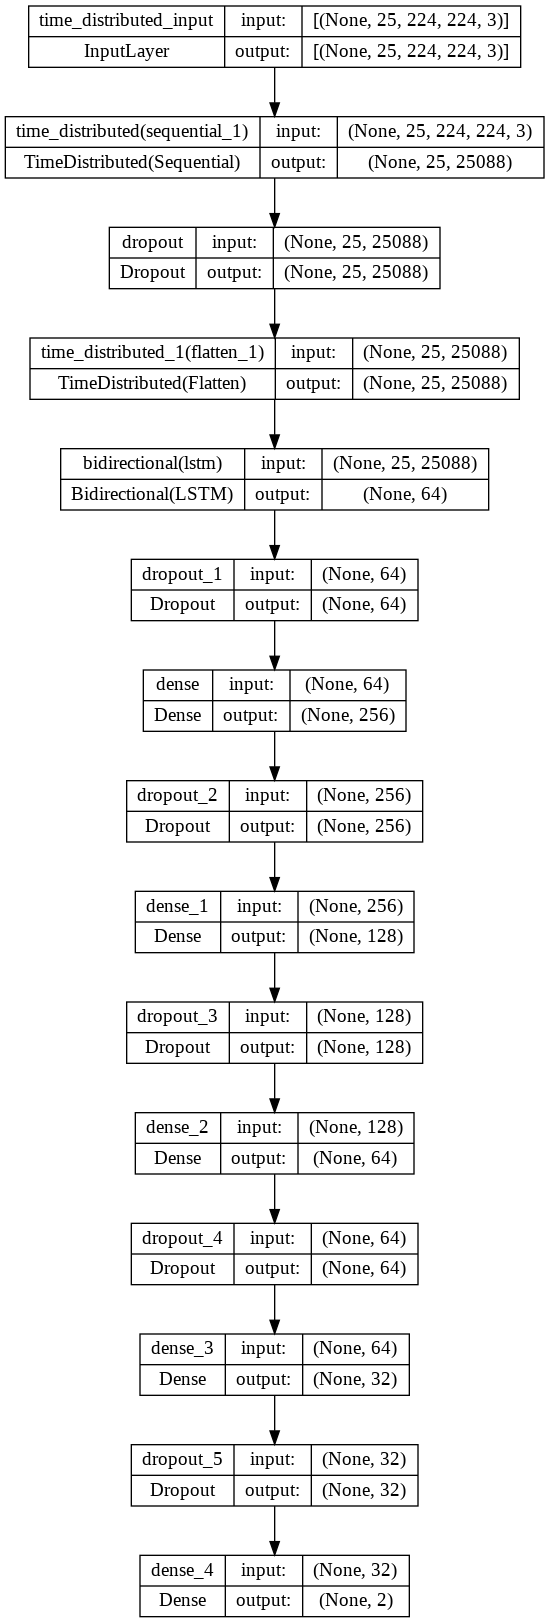

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(VGG19_model, to_file = 'VGG19_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
def generator_function():
    return video_gen.generator3D("Train")

def generator_function_valid():
    return video_gen.generator3D("Valid")

def generator_function_test():
    return video_gen.generator3D("Test")

In [ ]:
output_signature = (tf.TensorSpec(shape = (video_gen.batch_size_train, video_gen.time, video_gen.width, video_gen.height, video_gen.channels), dtype = tf.float32),
                    tf.TensorSpec(shape = (video_gen.batch_size_train,2), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(generator_function,output_signature = output_signature)
valid_ds = tf.data.Dataset.from_generator(generator_function_valid,output_signature = output_signature)

output_signature = (tf.TensorSpec(shape = (video_gen.batch_size_test, video_gen.time, video_gen.width, video_gen.height, video_gen.channels), dtype = tf.float32),
                    tf.TensorSpec(shape = (video_gen.batch_size_test,2), dtype = tf.int16))

test_ds = tf.data.Dataset.from_generator(generator_function_test,output_signature = output_signature)

#attention RAM prefetch
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.apply(tf.data.experimental.assert_cardinality(len(video_gen.ftr )//video_gen.batch_size_train)).prefetch(buffer_size=AUTOTUNE).cache()#.batch(BS,num_parallel_calls=True)
test_ds = test_ds.apply(tf.data.experimental.assert_cardinality(len(video_gen.fts )//video_gen.batch_size_test)).prefetch(buffer_size=AUTOTUNE).cache()#.batch(BS,num_parallel_calls=True)
valid_ds = valid_ds.apply(tf.data.experimental.assert_cardinality(len(video_gen.ftv )//video_gen.batch_size_valid)).prefetch(buffer_size=AUTOTUNE).cache()#.batch(BS,num_parallel_calls=True)


In [ ]:
#iteration = 1

#restore the best weights
#MoBiLSTM_model.load_weights('ModelWeights.h5')
# Fitting the model 
history = VGG19_model.fit(train_ds,#video_gen.generator3D("Test")
                          validation_data = valid_ds,#video_gen.generator3D("Valid")
                          epochs = 1, 
                          batch_size = video_gen.batch_size_train,
                          #shuffle = shuffle,
                          #validation_split = 0.2, 
                          callbacks = [early_stopping_callback,model_checkpoints,reduce_lr, tensorboard_callback],
                          #verbose=1,
                          steps_per_epoch=int(len(video_gen.ftr) / video_gen.batch_size_train)
                  )
#model_checkpoints

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.7023 - categorical_accuracy: 0.4858


Epoch 1: loss improved from inf to 0.70230, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 289s 7s/step - loss: 0.7023 - categorical_accuracy: 0.4858 - val_loss: 0.6922 - val_categorical_accuracy: 0.4980 - lr: 1.0000e-04
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.6986 - categorical_accuracy: 0.4798


Epoch 2: loss improved from 0.70230 to 0.69859, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 586ms/step - loss: 0.6986 - categorical_accuracy: 0.4798 - val_loss: 0.6855 - val_categorical_accuracy: 0.7267 - lr: 1.0000e-04
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.6875 - categorical_accuracy: 0.5405


Epoch 3: loss improved from 0.69859 to 0.68754, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 590ms/step - loss: 0.6875 - categorical_accuracy: 0.5405 - val_loss: 0.6858 - val_categorical_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.6755 - categorical_accuracy: 0.5972


Epoch 4: loss improved from 0.68754 to 0.67549, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 585ms/step - loss: 0.6755 - categorical_accuracy: 0.5972 - val_loss: 0.6450 - val_categorical_accuracy: 0.7348 - lr: 1.0000e-04
Epoch 5/10
38/38 [==============================] - ETA: 0s - loss: 0.6690 - categorical_accuracy: 0.5951


Epoch 5: loss improved from 0.67549 to 0.66900, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 587ms/step - loss: 0.6690 - categorical_accuracy: 0.5951 - val_loss: 0.6267 - val_categorical_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 6/10
38/38 [==============================] - ETA: 0s - loss: 0.6121 - categorical_accuracy: 0.6802


Epoch 6: loss improved from 0.66900 to 0.61210, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 600ms/step - loss: 0.6121 - categorical_accuracy: 0.6802 - val_loss: 0.5614 - val_categorical_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 7/10
38/38 [==============================] - ETA: 0s - loss: 0.5938 - categorical_accuracy: 0.7126


Epoch 7: loss improved from 0.61210 to 0.59376, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 587ms/step - loss: 0.5938 - categorical_accuracy: 0.7126 - val_loss: 0.6803 - val_categorical_accuracy: 0.5243 - lr: 1.0000e-04
Epoch 8/10
38/38 [==============================] - ETA: 0s - loss: 0.5419 - categorical_accuracy: 0.7490


Epoch 8: loss improved from 0.59376 to 0.54193, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 589ms/step - loss: 0.5419 - categorical_accuracy: 0.7490 - val_loss: 0.4730 - val_categorical_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 9/10
38/38 [==============================] - ETA: 0s - loss: 0.4890 - categorical_accuracy: 0.7935


Epoch 9: loss improved from 0.54193 to 0.48902, saving model to /content/drive/MyDrive/Colab_Notebooks/Results/ModelWeights.h5
38/38 [==============================] - 22s 585ms/step - loss: 0.4890 - categorical_accuracy: 0.7935 - val_loss: 0.4655 - val_categorical_accuracy: 0.8057 - lr: 1.0000e-04
Epoch 10/10
38/38 [==============================] - ETA: 0s - loss: 0.4894 - categorical_accuracy: 0.7672


Epoch 10: loss did not improve from 0.48902
38/38 [==============================] - 21s 556ms/step - loss: 0.4894 - categorical_accuracy: 0.7672 - val_loss: 0.3998 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04


In [ ]:
%tensorboard --logdir logs

In [ ]:
history = VGG19_model.fit(train_ds,#video_gen.generator3D("Test")
                          validation_data = valid_ds,#video_gen.generator3D("Valid")
                          epochs = 10, 
                          batch_size = video_gen.batch_size_train,
                          #shuffle = shuffle,
                          #validation_split = 0.2, 
                          callbacks = [early_stopping_callback,model_checkpoints,reduce_lr, tensorboard_callback],
                          #verbose=1,
                          steps_per_epoch=int(len(video_gen.ftr) / video_gen.batch_size_train)
                  )

In [ ]:
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000) 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


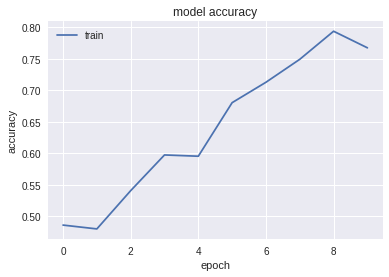

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

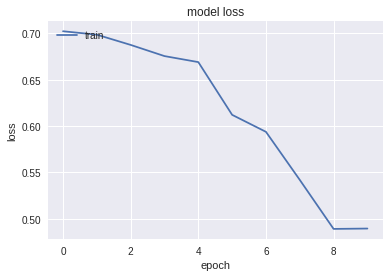

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
start = time.time()
video_gen.predictions = VGG19_model.predict(test_ds,
                                       steps=len(video_gen.fts) / video_gen.batch_size_test,
                                       max_queue_size=10,
                                       verbose=2)
end = time.time()
print('Inference time: ' + str((end - start)/len(video_gen.fts)))

video_gen.predictions = np.argmax(video_gen.predictions, axis=1)
test_accuracy = sklearn.metrics.accuracy_score(video_gen.fts_labels, video_gen.predictions, normalize=True)

1000/1000 - 102s - 102s/epoch - 102ms/step
Inference time: 0.10226708149909973


In [ ]:
VGG19_model.save(dir + 'Results/VG19_model.h5')

In [ ]:
print('Accurcay Score: ' + str(test_accuracy))

Accurcay Score: 0.805


In [ ]:
#add confusion matrix

In [ ]:
tf.compat.v1.enable_eager_execution()
graph = tf.compat.v1.get_default_graph()

In [ ]:
session = tf.compat.v1.Session()
graph = tf.compat.v1.get_default_graph()
#When you call base_model(input_data) it does not perform an actual computation, it just constructs the computation graph and returns the result tensor.
#It is only when you run a session, that the computation is performed and the output is generated.

#In this case, the code is specifically measuring the FLOPS and memory consumption of the model, and not the output of the model. So there is no need to run the session, since the profiler is only analyzing the operations and tensors in the graph.
#However, to measure the inference time, you need to feed data to the model and run the session, because the profiler is not able to measure the time taken to run the forward pass of the model.

with graph.as_default():
    with session.as_default():
        base_model = VGG19_model
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        # We use the Keras session graph in the call to the profiler.
        flops = tf.compat.v1.profiler.profile(graph=graph,
                                              run_meta=run_meta, cmd='op', options=opts)
        
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()
        params = tf.compat.v1.profiler.profile(graph, run_meta=run_meta, cmd='op', options=opts)
        # Print the FLOPS
        #flops = profiler.flops()
        print("Total FLOPS: ", flops.total_float_ops)
        # Print the memory consumption
        #memory_use = profiler.memory()
        print("Total memory consumption: ", params.total_parameters)

Total FLOPS:  117332702921
Total memory consumption:  219164874


In [ ]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

In [ ]:
#iteration += 1